# Pix2Pix - Image-to-Image Translation in Raw PyTorch

Ce notebook implémente l'architecture Pix2Pix (Isola et al., 2017) pour la traduction d'images (ex: croquis -> photo, jour -> nuit) en utilisant **PyTorch pur**.

## Objectifs Techniques
- **Architecture**: Generator U-Net + Discriminator PatchGAN.
- **Loss**: Adversarial Loss (BCE) + L1 Loss (Reconstruction).
- **Dataset**: Gestion d'images paires concaténées horizontalement.
- **Training**: Boucle d'entraînement personnalisée avec mises à jour alternées.

## Mises à jour v2 (Performance):
- **Instance Normalization**: Remplace BatchNorm (meilleur pour batch_size=1).
- **Spectral Normalization**: Ajouté au Discriminateur pour la stabilité.
- **LR Scheduler**: Décroissance du learning rate.

In [70]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. Configuration & Hyperparamètres

In [71]:
class Config:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LEARNING_RATE = 2e-4
    BATCH_SIZE = 1 
    NUM_WORKERS = 2
    IMAGE_SIZE = 256
    CHANNELS_IMG = 3
    L1_LAMBDA = 100 
    NUM_EPOCHS = 50 # Edges2Shoes converge plus lentement, mais on commence avec 50
    LOAD_MODEL = False
    SAVE_MODEL = True
    CHECKPOINT_DISC = "disc.pth.tar"
    CHECKPOINT_GEN = "gen.pth.tar"
    
    # --- CONFIGURATION DATASET ---
    # Edges2Shoes (Active par defaut maintenant)
    TRAIN_DIR = "/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/train"
    VAL_DIR = "/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val"
    
    # Facades (Commenté)
    # TRAIN_DIR = "/kaggle/input/pix2pix-dataset/facades/facades/train"
    # VAL_DIR = "/kaggle/input/pix2pix-dataset/facades/facades/val"
    
    # Limite pour debug (None = tout le dataset)
    TRAIN_SIZE_LIMIT = None 
    
print(f"Device used: {Config.DEVICE}")

Device used: cuda


## 2. Pipeline de Données (Paired Dataset)

In [72]:
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        if os.path.exists(root_dir):
            self.list_files = os.listdir(root_dir)
        else:
            print(f"Attention: Le dossier {root_dir} n'existe pas. Assurez-vous de charger vos donnees.")
            self.list_files = []

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        try:
            image = np.array(Image.open(img_path))
        except:
            return self.__getitem__(index + 1) # Skip corrupted images

        w = image.shape[1]
        cutoff = w // 2
        input_image = image[:, :cutoff, :] 
        target_image = image[:, cutoff:, :]

        aug_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((286, 286)),
            transforms.RandomCrop(Config.IMAGE_SIZE),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        # Augmentation manuelle pour garantir la meme transformation
        input_image = Image.fromarray(input_image)
        target_image = Image.fromarray(target_image)
        
        resize = transforms.Resize((286, 286))
        input_image = resize(input_image)
        target_image = resize(target_image)
        
        i, j, h, w_crop = transforms.RandomCrop.get_params(
            input_image, output_size=(Config.IMAGE_SIZE, Config.IMAGE_SIZE)
        )
        input_image = transforms.functional.crop(input_image, i, j, h, w_crop)
        target_image = transforms.functional.crop(target_image, i, j, h, w_crop)
        
        if torch.rand(1) > 0.5:
            input_image = transforms.functional.hflip(input_image)
            target_image = transforms.functional.hflip(target_image)
            
        base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        
        input_image = base_transform(input_image)
        target_image = base_transform(target_image)

        return input_image, target_image

## 3. Architecture du Discriminateur (PatchGAN) - Upgrade: SpectralNorm & InstanceNorm

In [73]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            # Spectral Norm stabilise l'entrainement du discriminateur
            nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect")),
            nn.InstanceNorm2d(out_channels, affine=True), # InstanceNorm est preferable pour Pix2Pix
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels * 2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect")),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect")
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        return self.model(x)

## 4. Architecture du Générateur (U-Net) - Upgrade: InstanceNorm

In [74]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            # InstanceNorm remplace BatchNorm
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.block(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(features * 2, features * 4, down=True, act="leaky", use_dropout=False)
        self.down3 = Block(features * 4, features * 8, down=True, act="leaky", use_dropout=False)
        self.down4 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.down5 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.down6 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1, padding_mode="reflect"),
            nn.ReLU(),
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up3 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up4 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False)
        self.up5 = Block(features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False)
        self.up6 = Block(features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False)
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        
        return self.final_up(torch.cat([u7, d1], 1))

## 5. Fonctions Utilitaires & Visualisation

In [75]:
def save_some_examples(gen, val_loader, epoch, folder):
    try:
        x, y = next(iter(val_loader))
    except StopIteration:
        return
    x, y = x.to(Config.DEVICE), y.to(Config.DEVICE)
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5
        x = x * 0.5 + 0.5
        y = y * 0.5 + 0.5
        save_image(y_fake, folder + f"/gen_{epoch}.png")
        save_image(x, folder + f"/input_{epoch}.png")
        save_image(y, folder + f"/label_{epoch}.png")
        
    gen.train()

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## 6. Boucle d'Entraînement (Update: Scheduler)

In [76]:
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x, y = x.to(Config.DEVICE), y.to(Config.DEVICE)
        
        with torch.amp.autocast('cuda'):
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        with torch.amp.autocast('cuda'):
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * Config.L1_LAMBDA
            G_loss = G_fake_loss + L1

        gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_loss=D_loss.item(),
                G_loss=G_loss.item(),
            )

## 7. Execution Principale

In [80]:
def main():
    disc = Discriminator(in_channels=3).to(Config.DEVICE)
    gen = Generator(in_channels=3, features=64).to(Config.DEVICE)
    
    disc.apply(weights_init)
    gen.apply(weights_init)
    
    opt_disc = optim.Adam(disc.parameters(), lr=Config.LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen = optim.Adam(gen.parameters(), lr=Config.LEARNING_RATE, betas=(0.5, 0.999))

    scheduler_gen = optim.lr_scheduler.StepLR(opt_gen, step_size=30, gamma=0.1)
    scheduler_disc = optim.lr_scheduler.StepLR(opt_disc, step_size=30, gamma=0.1)

    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    # --- Variables pour le suivi du meilleur modele ---
    best_val_l1 = float("inf")
    checkpoint_best_gen = "best_gen.pth.tar"
    checkpoint_best_disc = "best_disc.pth.tar"

    train_dataset = Pix2PixDataset(root_dir=Config.TRAIN_DIR)

    if Config.TRAIN_SIZE_LIMIT is not None and len(train_dataset) > Config.TRAIN_SIZE_LIMIT:
        print(f"Limitation du dataset train a {Config.TRAIN_SIZE_LIMIT} images.")
        indices = torch.randperm(len(train_dataset))[:Config.TRAIN_SIZE_LIMIT]
        train_dataset = torch.utils.data.Subset(train_dataset, indices)

    if len(train_dataset) > 0:
        train_loader = DataLoader(
            train_dataset,
            batch_size=Config.BATCH_SIZE,
            shuffle=True,
            num_workers=Config.NUM_WORKERS,
            pin_memory=True,
        )
        val_dataset = Pix2PixDataset(root_dir=Config.VAL_DIR)
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False) if len(val_dataset) > 0 else train_loader
        
        g_scaler = torch.amp.GradScaler('cuda')
        d_scaler = torch.amp.GradScaler('cuda')

        for epoch in range(Config.NUM_EPOCHS):
            print(f"Epoch [{epoch}/{Config.NUM_EPOCHS}] - LR: {scheduler_gen.get_last_lr()[0]}")
            
            # --- PHASE D'ENTRAINEMENT ---
            train_fn(
                disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler
            )
            
            # --- PHASE DE VALIDATION POUR CALCULER LE 'BEST' ---
            gen.eval()
            current_val_l1 = 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(Config.DEVICE), y.to(Config.DEVICE)
                    y_fake = gen(x)
                    l1 = L1_LOSS(y_fake, y)
                    current_val_l1 += l1.item()
            
            avg_val_l1 = current_val_l1 / len(val_loader)
            print(f"Validation L1 Loss: {avg_val_l1:.4f}")
            gen.train()

            # --- SAUVEGARDE SI AMELIORATION ---
            if avg_val_l1 < best_val_l1:
                best_val_l1 = avg_val_l1
                print(f"Nouveau record ! Sauvegarde du meilleur modele (L1: {best_val_l1:.4f})")
                torch.save(gen.state_dict(), checkpoint_best_gen)
                torch.save(disc.state_dict(), checkpoint_best_disc)

            # Sauvegarde periodique classique (optionnelle)
            if Config.SAVE_MODEL and epoch % 5 == 0:
                torch.save(gen.state_dict(), Config.CHECKPOINT_GEN)
                torch.save(disc.state_dict(), Config.CHECKPOINT_DISC)

            scheduler_gen.step()
            scheduler_disc.step()
            save_some_examples(gen, val_loader, epoch, folder="evaluation")
            
    else:
        print(f"Aucune image trouvee dans {Config.TRAIN_DIR}.")
if __name__ == "__main__":
    main()

Epoch [0/50] - LR: 0.0002


100%|██████████| 49825/49825 [43:23<00:00, 19.14it/s, D_loss=0.257, G_loss=19.3] 


Validation L1 Loss: 0.2071
Nouveau record ! Sauvegarde du meilleur modele (L1: 0.2071)
Epoch [1/50] - LR: 0.0002


100%|██████████| 49825/49825 [42:54<00:00, 19.36it/s, D_loss=0.466, G_loss=5.05]  


Validation L1 Loss: 0.1819
Nouveau record ! Sauvegarde du meilleur modele (L1: 0.1819)
Epoch [2/50] - LR: 0.0002


100%|██████████| 49825/49825 [42:45<00:00, 19.42it/s, D_loss=0.333, G_loss=7.83]  


Validation L1 Loss: 0.1809
Nouveau record ! Sauvegarde du meilleur modele (L1: 0.1809)
Epoch [3/50] - LR: 0.0002


  2%|▏         | 1027/49825 [00:53<41:59, 19.37it/s, D_loss=0.424, G_loss=9.97]


KeyboardInterrupt: 

## 8. Inférence & Démo

--- Lancement de l'Inference ---


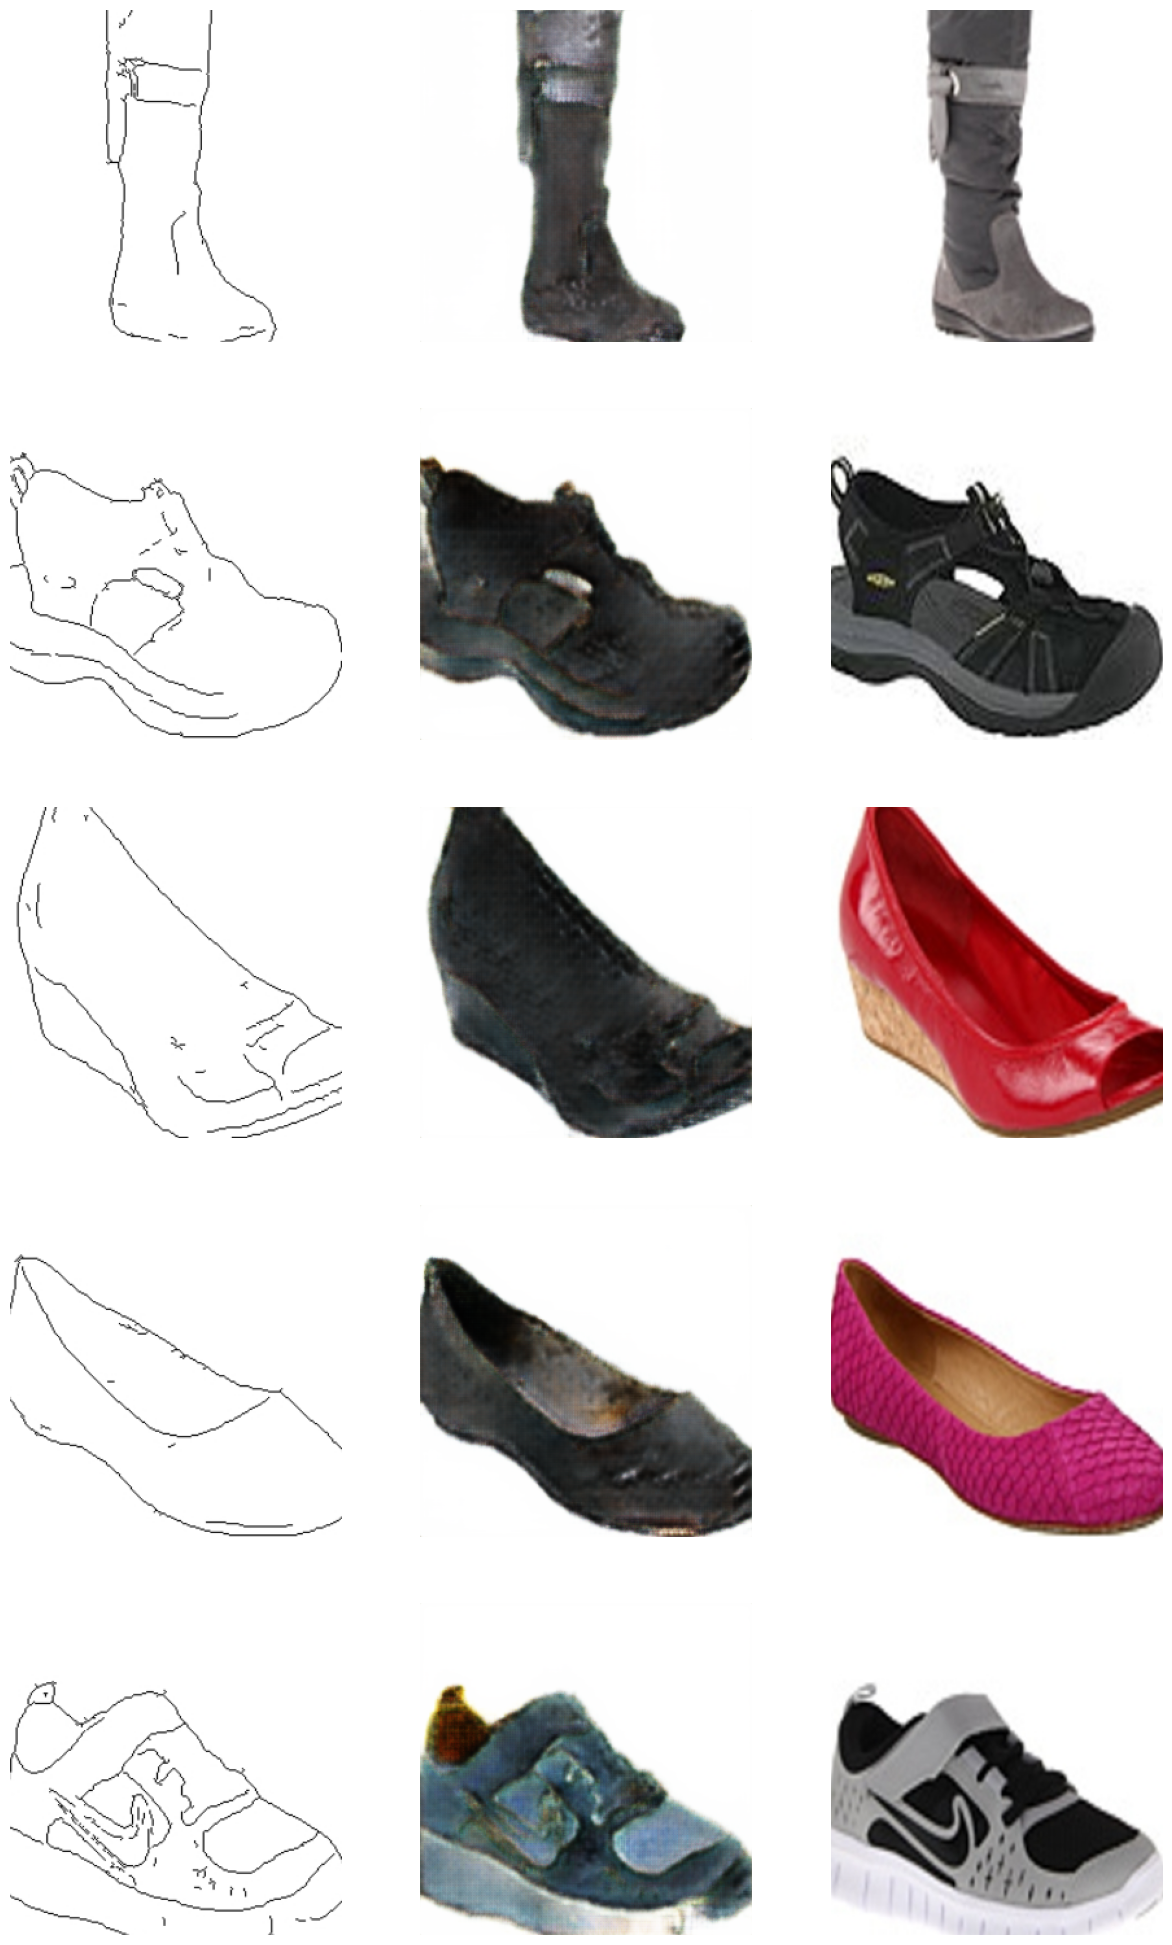

In [81]:
def run_inference():
    print("--- Lancement de l'Inference ---")
    gen = Generator(in_channels=3, features=64).to(Config.DEVICE)
    
    if os.path.exists(Config.CHECKPOINT_GEN):
        checkpoint = torch.load(Config.CHECKPOINT_GEN, map_location=Config.DEVICE)
        gen.load_state_dict(checkpoint)
        gen.eval()
    else:
        print("Pas de checkpoint trouve.")
        return

    val_dataset = Pix2PixDataset(root_dir=Config.VAL_DIR)
    if len(val_dataset) == 0: 
        print("Pas de dataset validation disponible")
        return
        
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
    n_samples = 5
    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))
    
    with torch.no_grad():
        for i, (x, y) in enumerate(val_loader):
            if i >= n_samples: break
            x = x.to(Config.DEVICE)
            y_fake = gen(x).cpu()
            x = x.cpu()
            
            x = x * 0.5 + 0.5
            y = y * 0.5 + 0.5
            y_fake = y_fake * 0.5 + 0.5
            
            axes[i, 0].imshow(x.squeeze().permute(1, 2, 0))
            axes[i, 0].axis("off")
            
            axes[i, 1].imshow(y_fake.squeeze().permute(1, 2, 0))
            axes[i, 1].axis("off")

            axes[i, 2].imshow(y.squeeze().permute(1, 2, 0))
            axes[i, 2].axis("off")
    plt.show()

def predict_custom_sketch(image_path):
    print(f"--- Prediction sur {image_path} ---")
    gen = Generator(in_channels=3, features=64).to(Config.DEVICE)
    if os.path.exists(Config.CHECKPOINT_GEN):
        gen.load_state_dict(torch.load(Config.CHECKPOINT_GEN, map_location=Config.DEVICE))
        gen.eval()
    else:
        print("Erreur: Pas de checkpoint.")
        return

    if not os.path.exists(image_path):
        print("Image introuvable")
        return
        
    img = Image.open(image_path).convert("RGB")
    t = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    x = t(img).unsqueeze(0).to(Config.DEVICE)
    with torch.no_grad():
        res = gen(x).squeeze().cpu() * 0.5 + 0.5
        plt.imshow(res.permute(1, 2, 0))
        plt.show()

run_inference()
